In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pickle

df = pd.read_csv("../datasets/sample_scan_activity.csv")
df.head()

,goat_id,date,total_scans,mean_interval_min,variance_interval,activity_score
0,G001,2024-09-01,14,32,120,0.82
1,G002,2024-09-01,9,45,160,0.61
2,G003,2024-09-01,4,78,310,0.29
3,G004,2024-09-01,16,28,115,0.88
4,G005,2024-09-01,6,70,280,0.42


In [2]:
features = [
    'total_scans',
    'mean_interval_min',
    'variance_interval',
    'activity_score'
]

X = df[features]
X.head()

,total_scans,mean_interval_min,variance_interval,activity_score
0,14,32,120,0.82
1,9,45,160,0.61
2,4,78,310,0.29
3,16,28,115,0.88
4,6,70,280,0.42


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
iso = IsolationForest(
    n_estimators=200,
    contamination=0.2,   # assume around 7 percent anomalies
    random_state=42
)

iso.fit(X_scaled)

,n_estimators,200
,max_samples,'auto'
,contamination,0.2
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [5]:
df['anomaly_flag'] = iso.predict(X_scaled)
df['anomaly_score'] = iso.decision_function(X_scaled)
df.head()

,goat_id,date,total_scans,mean_interval_min,variance_interval,activity_score,anomaly_flag,anomaly_score
0,G001,2024-09-01,14,32,120,0.82,1,0.111875
1,G002,2024-09-01,9,45,160,0.61,1,0.078601
2,G003,2024-09-01,4,78,310,0.29,1,0.109903
3,G004,2024-09-01,16,28,115,0.88,1,0.085445
4,G005,2024-09-01,6,70,280,0.42,1,0.053871


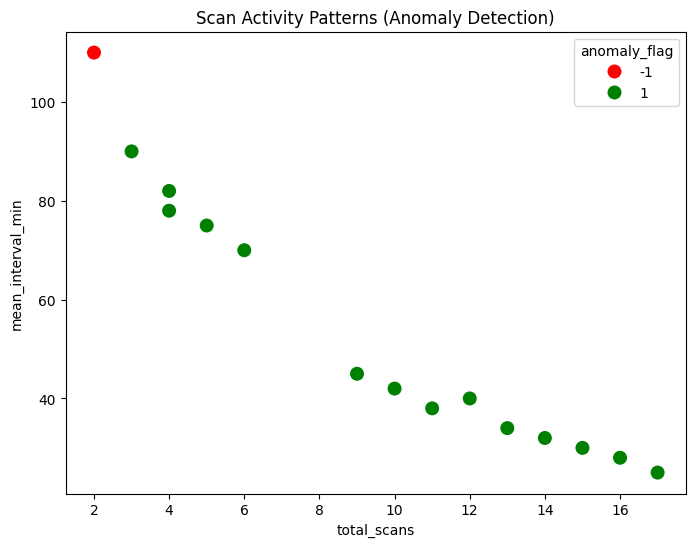

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='total_scans', y='mean_interval_min',
    hue='anomaly_flag',
    palette={1: "green", -1: "red"},
    s=120
)
plt.title("Scan Activity Patterns (Anomaly Detection)")
plt.show()

In [7]:
df['anomaly_flag'].value_counts()

anomaly_flag
 1    14
-1     1
Name: count, dtype: int64

In [8]:
with open("../models/anomaly_detector.pkl", "wb") as f:
    pickle.dump(iso, f)

with open("../models/anomaly_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Anomaly model + scaler saved successfully.")

Anomaly model + scaler saved successfully.


In [9]:
def detect_anomaly(sample_dict):
    """
    sample_dict example:
    {
        'total_scans': 4,
        'mean_interval_min': 78,
        'variance_interval': 310,
        'activity_score': 0.29
    }
    """
    df_sample = pd.DataFrame([sample_dict])
    
    # Load saved models
    scaler_loaded = pickle.load(open("../models/anomaly_scaler.pkl", "rb"))
    model_loaded = pickle.load(open("../models/anomaly_detector.pkl", "rb"))
    
    # Scale input
    X_scaled = scaler_loaded.transform(df_sample)
    
    flag = model_loaded.predict(X_scaled)[0]
    score = model_loaded.decision_function(X_scaled)[0]
    
    return {
        "anomaly_flag": int(flag),
        "anomaly_score": float(score)
    }

In [13]:
example = {
    'total_scans': 3,
    'mean_interval_min': 90,
    'variance_interval': 350,
    'activity_score': 0.22
}

detect_anomaly(example)

{'anomaly_flag': 1, 'anomaly_score': 0.03444425227378156}